<a href="https://colab.research.google.com/github/hookskl/nlp_w_pytorch/blob/main/nlp_w_pytorch_ch8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Sequence Modeling for NLP

Building on the techniques of sequence modeling, *sequence-to-sequence modeling* (seq2seq) is where a model takes a sequence as input and produces another sequence, possibly of different length. Examples of seq2seq include:

* given an email, predict a response
* given a sentence in French, predict its English translation
* given an article, create an abstract summarization


## Sequence-to-Sequence Models, Encoder-Decoder Models, and Conditioned Generation

Sequence-to-Sequence models are a special case of a family of models called *encoder-decoder models.* Encoder-decoder models comprise two models which are generally jointly trained together. The encoder model takes an input and produces an encoding/representation of the input, denoted as $\phi$, which is typically a vector. The encoder is intended to capture important properties of the input with respect to the task at hand. The decoder is intended to take $\phi$ as input and produce a desired output. In the context of encoder-decoder models, seq2seq models can be defined as encoder-decoder models in which both the encoder and decoder are sequence models and the inputs and outputs are both sequences, possibly of varying lengths.

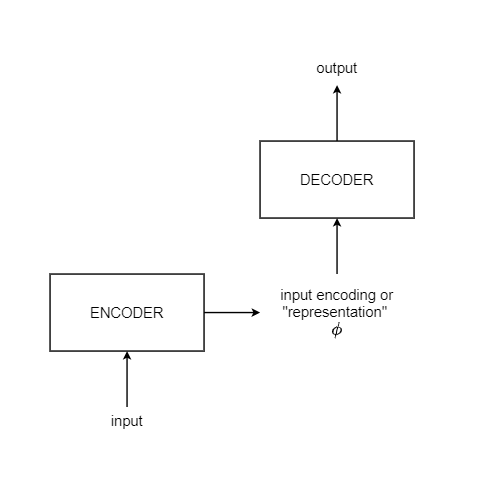

Encoder-decoder models can be viewed as a special case of *conditioned generation models*. Instead of relying on the input representation $\phi$, a general conditioning context $\textbf{c}$ influences a decoder to produce an output. If the conditioning context $\textbf{c}$ comes from an encoder then the conditioned generation model is the same as an encoder-decoder model. However, not all conditioned generation models are encoder-decoder models. For example, consider a weather report generator. The decoder for this model could be conditioned using the values of temperature, humidity, and wind speed and direction. Since these sources are structured and not an encoded representation of some input, this model would not be an encoder-decoder model.

One common use of seq2seq models is their application to machine translation tasks. For instance, consider a smartphone keyboard that automatically converts texts into emojis as they are typed. A single token in the input can produce zero or more tokens in the output. Pictured below is an input sequence "translated" into emojis, where the input text is six tokens and the output is four tokens. The mapping between the input and output is called *alignment*.

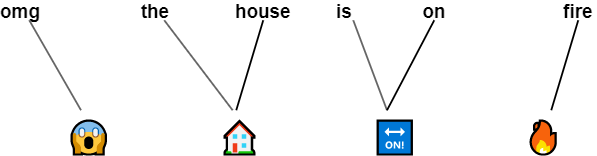

As pictured below, this translation can be modeled using an encoder-decoder structure. The encoder takes as input the text and creates a representation $\phi$ that is used to condition the decoder model to generate the correct output. For an encoder any RNN can be used (Elman, LSTM, GRU). Two vital components of modern-day seq2seq models are bidirectional RNNs and the attention mechanism. A bidirectional RNN combines iterating over an input sequence both forwards and backward to create a richer representation. Attention allows a model to focus on different parts of a sequence that are relevant for the task.

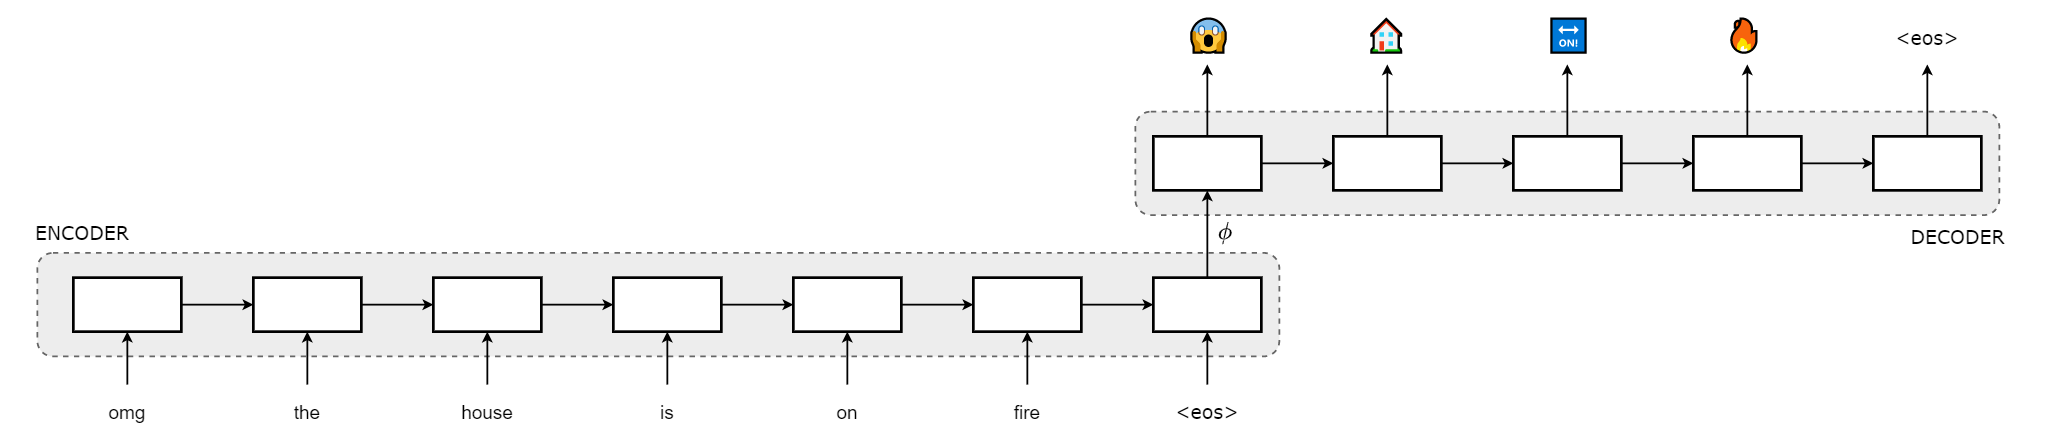

### Capturing More from a Sequence: Bidirectional RNNs

To understand the usefulness of bidirectional models, take the sentence:

 $$\text{The man who hunts ducks out on the weekends.}$$


When observing only left to right, the model's representation of "ducks" would be different than that of a model observing the sequence from right to left. 

Combining both directions allows for a more robust representation of a word in the sequence. This is precisely the goal of bidirectional RNNs. Any type of RNN can be formulated as a bidirectional RNN (bi-RNN) and any bi-RNN can be used in both classification and sequence labeling settings, for which the goal is to predict the label per word in the input.

Pictured below is an example of a bidirectional model that creates a forward representation ($\phi^f$) and backward representation ($\phi^b$) of the entire sequence before creating the final representation $\phi$. 

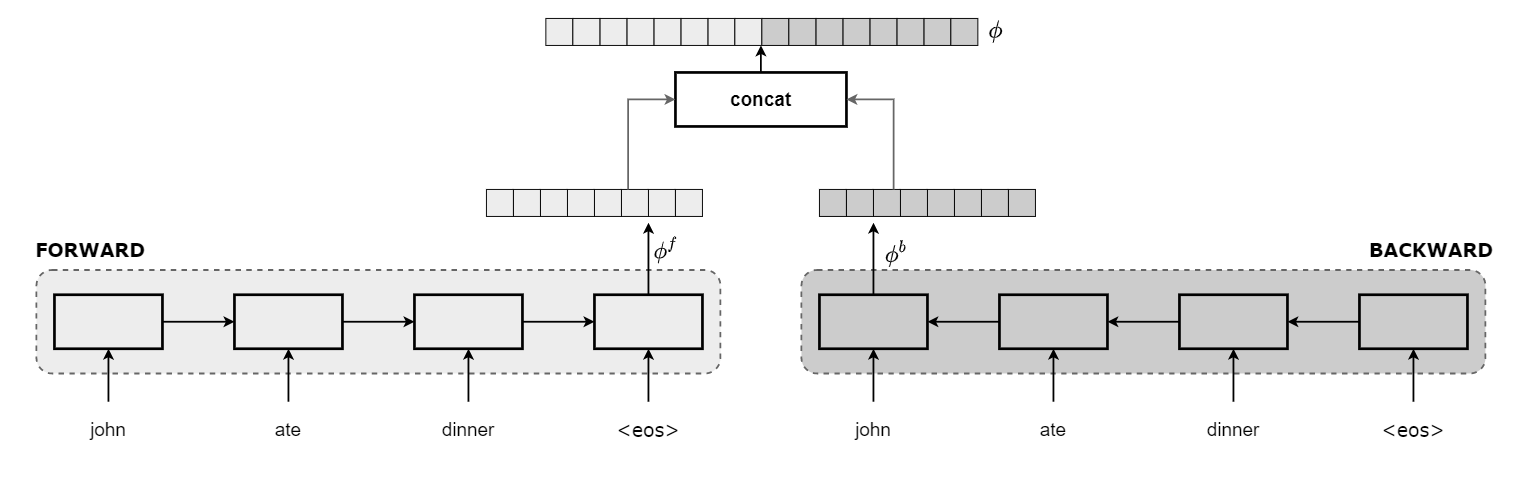

An important variation of this is create a forward and backward representation at each time step (each token). This is particulary important when using the attention mechanism.

### Capturing More from a Sequence: Attention

A shortcoming of seq2seq models is when the encoder needs to "cram" a very long sequence into a single representation $\phi$. As the length of the sequence increases the final representation $\phi$ fails to capture all of the relevant information about the input sequence. Additionally, as the input sequence increases the gradients begin to vanish when back-propagating through time, causing training to be very difficult.

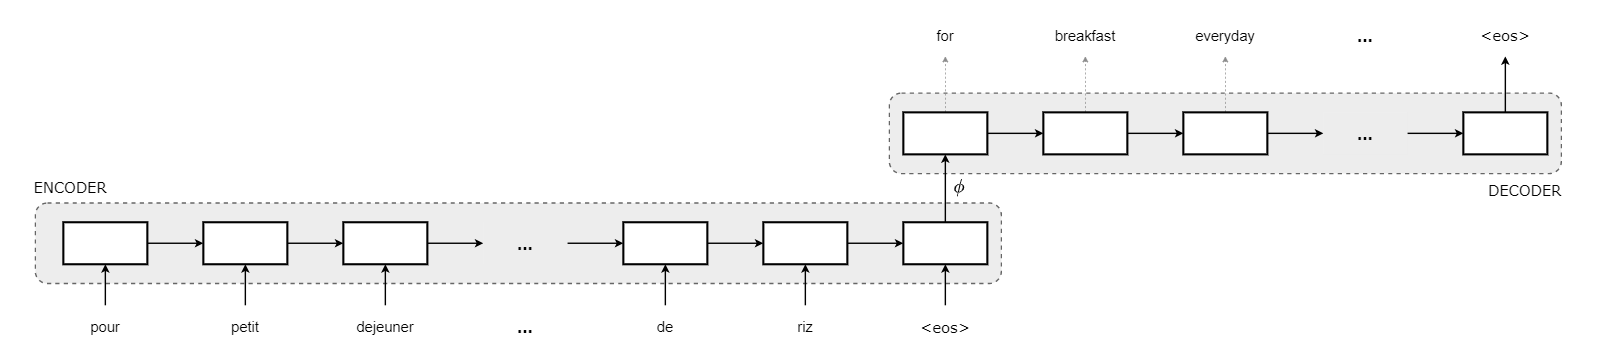

Intuitively, this shortcoming of seq2seq models struggling with longer inputs makes sense. To a person that is bilingual, translating a sentence from French to English does not come after distilling the entire French sentence to a single meaning. Rather, when the French word *pour* appears, it is immediately understand there is a *for* in the translation. Similarly, when seeing *petit-dejeuner* the immediate translataion is *breakfast*. The translator's mind is focusing on relevant parts of the sentence as the translation unfolds, which is the phenomenon known as *attention*.

Similar to the concept of attention, the *attention mechanism* allows sequence generation models to "attend to" different parts of the input to improve the quality of the output generated. In fact, it has been shown empirically in the area of machine translataion that model performance degrades with longer input sequences without the use of attention. Adding attention removes the degradation in performance. 

#### Attention in Deep Neural Networks

Attention is a general mechanism used in many types of models, but is described here in the context of encoder-decoder models. In a typical seq2seq model, each time step generates a hidden state ($\phi_{word}$), specific to that time step in the encoder. To implement attention, now instead of focusing on just the final representation $\phi$ of the encoder, all intermediate hidden states are used. In the terminology of attention, these intermediate states are called *values* (and also *keys* depending on the situation). Attention also requires the previous hidden state of the **decoder**, referred to as the *query*. Pictured below is a summary of this at time step 0.

The query for time step $t=0$ is a fixed hyperparameter. Attention is represented by a vector with the same dimension as the number of values it is attending to (also called the *attention vector*, or *attention weights*, or *alignment*). The attention weights are combined with the encoder states ("values") to generate a *context vector*. This context becomes the input to the decoder at the current time step instead of the full sentence representation. Finally, the attention vector for the next time step is update using a *compatibility function*. How this function works depends on the attention mechanism used. 

There are several ways to implement attention. A simple and commonly user version is *content-aware* attention (this is implemented later on). Another popular version is *location-aware* attention, which depends only on the query vector and the key. The attention weights are typically floating point values between 0 and 1. This is called *soft attention*. It is also possibly to learn an attention vector where the weights are binary (0/1). This is referred to as *hard attention*.

The attention pictured below depends on the encoder states for all time steps in the input. This is *global attention*. A windowed version, called *local attention*, takes a narrower view around the current time step. 

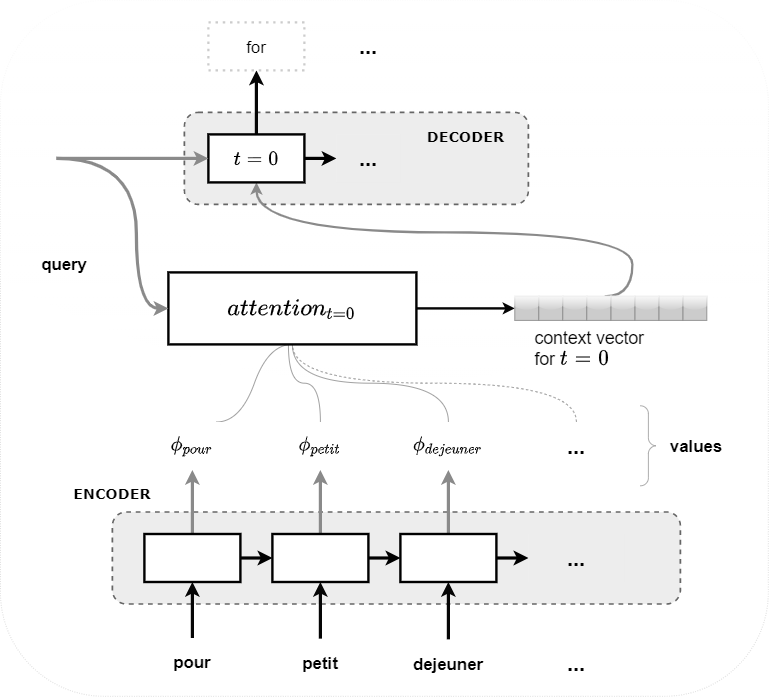

## Evaluating Sequence Generation Models

Unlike classification models, sequence generation models cannot be evaluated using metrics such as precision, recall, accuracy, or F1 scores. This is due to sequence generation models having multiple valid outputs for a given input. Take translating a sentence from French to English, for one French sentence there exists multiple valid translations in English. When comparing multiple sequence generation models against a *reference output*, the scores used should indicate "goodness" of the model's output (i.e. how close the output is to the reference). There are two methods for evaluating sequence generation models: human evaluation and automatic evaluation. 

Human evaluation involves one or more human evaluators rating a model's output as "good" or "bad" or making edits to correct the output. While this type of evaluation is important and very useful, it is also very costly and can have incosistency amonst different evaluators. Additionaly, human evaluation tends to be very slow as compared to automatic evaluation.

In terms of automatic evalutaion, there are two metrics for scoring a model's output: *n-gram overlap metrics* and *perplexity*. N-gram overlap metrics measure how close a model's output is with respect to a reference output by computing a score using n-gram overlap statistics. While there are several methods for doing so, the scoring system most broadly use is BLEU (BiLingual Evaluation Understudy). Python packages NLTK and SacreBLEU allow for computing BLEU scores quickly and easily. 

Perplexity comes from information theory and can be applied to any situation where the probability of an output sequence can be measured. For a given sequence $x$, where $P(x)$ is the probability of the sequence, perplexity is defined as:

$$Perplexity(x)=2^{-P(x)logP(x)}$$

While easy to compute, perplexity does come with some downsides. Most notably, perplexity is an inflated metric. Since the metric involves exponentiation, minor differences in improvements tend to be inflated when reflected in the overall score. 

### Example: Neural Machine Translation

### The Machine Translation Dataset

The dataset used is English-French sentence pairs from the Tatoeba Project. Preprocessing steps include:

* lowercase all sentences
* apply NLTK's language specific **sentence** tokenizers
* apply NLTK's language specific **word** tokenizers

This preprocessing outputs a list of tokens, which could be used as the final processed dataset. However, to speed up model training, a subset of sentence pairs were chosen based on English sentences starting with: "i am", "he is", "she is", "they are", "you are", or "we are". Narrowing the scope of the dataset accomplishes a few things. First, it reduces the dataset from ~135,000 sentence pairs to ~13,000. Next, this reduces the variation within the dataset and allows for high performance with less training time. 

Once all processing is finished the dataset is split into the standard: 

* train (70%)
* validation (15%)
* test (15%)

This splitting also maintains proportionality between the word pairs described earlier.

### A Vectorization Pipeline for NMT

The vectorization pipeline for this translation task has added complexity from standard classification tasks. This is due to two major reasons:

1. the source and target sequences have different roles within the model, are from different languages and are vectorized differently
2. PyTorch's `PackedSequences` data structure is needed, and as a prerequisite each minibatch must be sorted by the length of the **source** sentences

To handle this addtional complexity the `NMTVectorizer` is instantiated with two separate `SequenceVocabulary` objects and two measurements of max sequence length.

*Example 8-1. Constructing the `NMTVectorizer`*

```
class NMTVectorizer(object):
    """The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, source_vocab, target_vocab, max_source_length, 
                 max_target_length):
        """
        Args:
            source_vocab (SequenceVocabulary): maps source words to integers
            target_vocab (SequenceVocabulary): maps target words to integers
            max_source_length (int): the longest sequence in the source dataset
            max_target_length (int); the longest sequence in the target dataset
        """
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab

        self.max_source_length = max_source_length
        self.max_target_length = max_target_length

    @classmethod
    def from_dataframe(cls, bitext_df):
        """Instantiate the vectorizer from the dataset dataframe

        Args:
            bitext_df (pandas.DataFrame): the parallel text dataset
        Returns:
            an instance of the NMTVectorizer
        """
        source_vocab = SequenceVocabulary()
        target_vocab = SequenceVocabulary()
        max_source_length, max_target_length = 0, 0

        for _, row in bitext_df.iterrows():
            source_tokens = row["source_language"].split(" ")
            if len(source_tokens) > max_source_length:
                max_source_length = len(source_tokens)
            for token in target_tokens:
                target_vocab.add_token(token)

        return cls(source_vocab, target_vocab, max_source_length,
                   max_target_length)
```
The source sequence is vectorized with the `BEGIN-OF-SEQUENCE` and `END-OF-SEQUENCE` tokens prepended and appended respectively. The encoder for this model is a `bi-GRU` that creates a summary vector for each token of the source sequence. While these boundary tokens are not required, the encoder benefits greatly from their addition.

The target sequence is vectorized as two copies offset by one token: the first copy needs the `BEGIN-OF-SEQUENCE` token and the second copy requires the `END-OF-SEQUENCE` token. This format is similar to that of the sequence generation task used to create new surnames. Here, this is exactly what the decoder model is doing, with the added information from the context vector provided by the encoder.

Due to having two different methods of vectorization, a more general method `_vectorize()` is written to accept either the source or target indices. Then, two methods are written specific to the needs of the target and source sequences. The indices generated are coordinated by the `NMTVectorizer.vectorize` method, which is invoked by the dataset.

*Example 8-2. The vectorization functions in the `NMTVectorizer`*

```
class NMTVectorizer(object):
    """The Vectorizer which coordinates the Vocabularies and puts them to use"""
    # ...
    def _vectorizer(self, indices, vector_length=-1, mask_index=0):
        """Vectorize the provided indices
        Args:
            indices (list): a list of integers that represent a sequence
            vector_length (int): forces the length of the index vector
            mask_index (int): the mask_index to use; almost always 0
        """
        if vector_length < 0:
            vector_length = len(indices)
        vector = np.zeros(vector_length, dtype=np.int64)
        vector[:len(indices)] = indices
        vector[len(indices):] = mask_index
        return vector

    def _get_source_indices(self, text):
        """Return the vectorized source text

        Args:
            text (str): the source text; tokens should be separated by spaces
        Returns:
            indices (list): list of integers representing the text
        """
        indices = [self.source_vocab.begin_seq_index]
        indices.extend(self.source_vocab.lookup_token(token)
                       for token in text.split(" "))
        indices.append(self.source_vocab.end_seq_index)
        return indices

    def _get_target_indices(self, text):
        """Return the vectorized source text

        Args:
            text (str): the source text; tokens should be separated by spaces
        Returns:
            a tuple (x_indices, y_indices)
                x_indices (list): list of ints; observations in target decoder
                y_indices (list): list of ints; predictions in target decoder
        """
        indices = [self.target_vocab.lookup_vocab(token)
                   for token in text.split(" ")]
        x_indices = [self.target_vocab.begin_seq_index] + indices
        y_indices = indices + [self.target_vocab_end_seq_index]
        return x_indices, y_indices

    def vectorize(self, source_text, target_text, use_dataset_max_lengths=True):
        """Return the vectorized source and target text

        Args:
            source_text (str): text from the source language
            target_text (str): text from the target language
            use_dataset_max_lengths (bool): whether to use the max vector lengths
        Returns:
            the vectorized data point as a dictionary with the keys:
                source_vector, target_x_vector, target_y_vector, source_length
        """
        source_vector_length = -1
        target_vector_length = -1

        if use_dataset_max_lengths:
            source_vector_length = self.max_source_length + 2
            target_vector_length = self.max_target_length + 1

        source_indices = self._get_source_indices(source_text)   
        source_vector = self._vectorize(source_indices,
                                        vector_length=source_vector_length,
                                        mask_index=self.source_vocab.mask_index)

        target_x_indices, target_y_indices = self._get_target_indices(target_text)
        target_x_vector = self._vectorize(target_x_indices,
                                          vector_length=target_vector_length,
                                          mask_index=self.target_vocab.mask_index)
        return {"source_vector": source_vector,
                "target_x_vector": target_x_vector,
                "target_y_vector": target_y_vector,
                "source_length": len(source_indices)}
```

The second complexity to deal with is properly encoding the source sequence. Since a `bi-GRU` is used as the encoder, padding the source sequences with `0`'s to consistent lengths would cause the backward pass of the `bi-GRU` to pass through potentially many sequences of padding. Instead, the `PackedSequence` data structure provides another, more efficient representation. This structure represents variable-length sequences as an array by concatenating the data for the sequences at each time step, one after another, while knowing the number of sequences at each time step. 

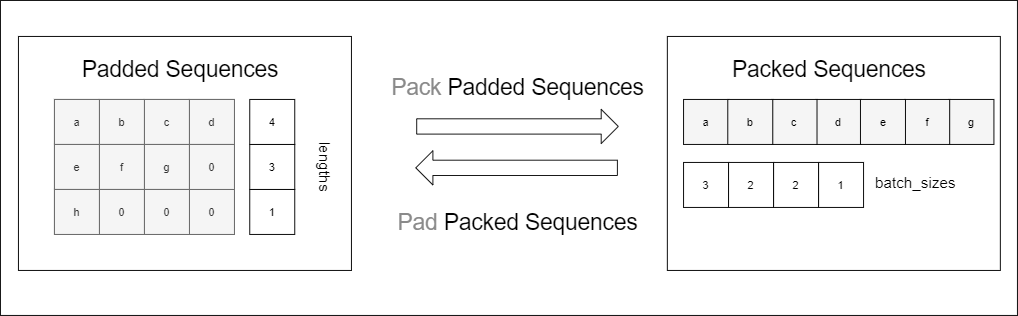

There are two prerequisites when creating a `PackedSequence`:

1. knowing the length of each sequence
2. sorting the sequences in descending order by the length of the source sequence

To maintain parity with the newly sorted matrix, all remaining tensors are also sorted in the same order.

*Example 8-3. Generating minibatches for the NMT*

```
def generate_nmt_batches(dataset, batch_size, shuffle=True,
                         drop_last=True, device='cpu'):
    """A generator function which wraps the PyTorch DataLoader; NMT version"""
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        lengths = data_dict['x_source_length'].numpy()
        sort_length_indices = lengths.argsort()[::-1].tolist()

        out_data_dict = {}
        for name, tensor in data_dict.items()
            out_data_dict[name] = data_dict[name][sorted_length_indices].to(device)
        yield out_data_dict
```

### Encoding and Decoding in the NMT Model

*Example 8-4. The `NMTModel` encapsulates and coordinates the encoder and decoder in a single `forward()` method*

```
class NMTModel(nn.Module):
    """The Neural Machine Translation Model"""
    def __init__(self, source_vocab_size, source_embedding_size,
                 target_vocab_size, target_embedding_size, encoding_size,
                 target_bos_index):
    """
    Args:
        source_vocab_size (int): number of unique words in source language
        source_embedding_size (int): size of the source embedding vectors
        target_vocab_size (int): number of unqiue words in target language
        target_embedding_size (int): size of the target embedding vectors
        encoding_size (int): size of the encoder RNN
        target_bos_index (int): index for BEGIN-OF-SEQUENCE token
    """
    super(NMTModel, self).__init__()
    self.encoder = NMTEncoder(num_embeddings=source_vocab_size,
                              embedding_size=source_embedding_size,
                              rnn_hidden_size=encoding_size)
    decoding_size = encoding_size * 2
    self.decoder = NMTDecoder(num_embddings=target_vocab_size,
                              embedding_size=target_embedding_size,
                              rnn_hidden_size=decoding_size,
                              bos_index=target_bos_index)

    def forward(self, x_source, x_source_lengths, target_sequence):
        """the forward pass of the model

        Args:
            x_source (torch.Tensor): the source text data tensor
                x_source.shape should be (batch, vectorizer.max_source_length)
            x_source_lengths (torch.Tensor): the length of the sequences in x_source
            target_sequence (torch.Tensor): the target next data tensor
        Returns:
            decoded_states (torch.Tensor): prediction vectors at each output step
        """
        encoder_state, final_hidden_states = self.encoder(x_source,
                                                          x_source_lengths)
        decoded_states = self.decoder(encoder_state=encoder_state,
                                      initial_hidden_state=final_hidden_states,
                                      target_sequence=target_sequence)
        return decoded_states                                                                                                                                      
```

*Example 8-5. The encoder embeds the source words and extracts features with a bi-GRU*

```
class NMTEncoder(nn.Module):
    def __init__(self, num_embeddings, embedding_size, rnn_hidden_size):
        """
        Args:
            num_embeddings (int): size of source vocabulary
            embedding_size (int): size of the embedding vectors
            rnn_hidden_size (int): size of the RNN hidden state vectors
        """
        super(NMTEncoder, self).__init__()

        self.source_embedding = nn.Embedding(num_embeddings, embedding_size,
                                             padding_idx=0)
        self.birnn = nn.GRU(embedding_size, rnn_hidden_size, bidirectional=True,
                            batch_first=True)

    def forward(self, x_source, x_lengths):
        """the forward pass of the model

        Args:
            x_source (torch.Tensor): the input data tensor
                x_source.shape is (batch, seq_size)
            x_lengths (torch.Tensor): vector of lengths for each item in batch
        Returns:
            a tuple: x_unpacked (torch.Tensor), x_birnn_h (torch.Tensor)
                x_unpacked.shape = (batch, seq_size, rnn_hidden_size * 2)
                x_birnn_h.shape = (batch, rnn_hidden_size * 2)
        """
        x_embedded = self.source_embedding(x_source)
        # create PackedSequence; x_packed.data.shape=(number_items,
        #                                    embedding_size)
        x_lengths = x_lengths.detach().cpu().numpy()
        x_packed = pack_padded_sequence(x_embedded, x_lengths, batch_first=True)

        # x_birnn_h.shape = (num_rnn, batch_size, feature_size)
        x_birnn_out, x_birnn_h = self.birnn(x_packed)
        # permute to (batch_size, num_rnn, feature_size)
        x_birnn_h = x_birnn_h.permute(1, 0, 2)

        # flatten features; reshape to (batch_size, num_rnn * feature_size)
        # (recall: -1 takes the remaining positions,
        #          flattening the twho RNN hidden vectors into 1)
        x_birnn_h = x_birnn_h.contiguous().view(x_birnn_h.size(0), -1)

        x_unpacked, _ = pad_packed_sequence(x_birnn_out, batch_first=True)
        return x_unpacked, x_birnn_h
```

*Example 8-6. A simple demonstration of `packed_padded_sequences` and `pad_packed_sequences`*

In [11]:
import torch
import torch.nn.utils.rnn as rnn

def describe(x):
    print("Type: {}".format(x.type()))
    print("Shape/size: {}".format(x.shape))
    print("Values: \n{}".format(x))

abcd_padded = torch.tensor([1, 2, 3, 4], dtype=torch.float32)
efg_padded = torch.tensor([5, 6, 7, 0], dtype=torch.float32)
h_padded = torch.tensor([8, 0, 0, 0], dtype=torch.float32)

padded_tensor = torch.stack([abcd_padded, efg_padded, h_padded])

describe(padded_tensor)
print("\n"+"="*30)

lengths = [4, 3, 1]
packed_tensor = rnn.pack_padded_sequence(padded_tensor, lengths,
                                     batch_first=True)
print(packed_tensor)
print("\n"+"="*30)

unpacked_tensor, unpacked_lengths = \
    rnn.pad_packed_sequence(packed_tensor, batch_first=True)

describe(unpacked_tensor)
print("\n"+"="*30)
describe(unpacked_lengths)   
print("\n"+"="*30)

Type: torch.FloatTensor
Shape/size: torch.Size([3, 4])
Values: 
tensor([[1., 2., 3., 4.],
        [5., 6., 7., 0.],
        [8., 0., 0., 0.]])

PackedSequence(data=tensor([1., 5., 8., 2., 6., 3., 7., 4.]), batch_sizes=tensor([3, 2, 2, 1]), sorted_indices=None, unsorted_indices=None)

Type: torch.FloatTensor
Shape/size: torch.Size([3, 4])
Values: 
tensor([[1., 2., 3., 4.],
        [5., 6., 7., 0.],
        [8., 0., 0., 0.]])

Type: torch.LongTensor
Shape/size: torch.Size([3])
Values: 
tensor([4, 3, 1])



*Example 8-7. The `NMTDecoder` constructs a target sentence from the encoded source sentence*

```
class NMTDecoder(nn.Module):
    def __init__(self, num_embeddings, embedding_size, rnn_hidden_size, bos_index):
        """
        Args:
            num_embeddings (int): number of embeddings; also the number of
                unique words in the target vocabulary
            embedding_size (int): size of the embedding vector
            rnn_hidden_size (int): size of the hidden RNN state
            bos_index (int): BEGIN-OF-SEQUENCE index
        """
        super(NMTDecoder, self).__init__()
        self._rnn_hidden_size = rnn_hidden_size
        self.target_embedding = nn.Embedding(num_embeddings=num_embeddings,
                                             embedding_dim=embedding_size,
                                             padding_idx=0)
        self.gru_cell = nn.GRUCell(embedding_size + rnn_hidden_size, 
                                   rnn_hidden_size)
        self.hidden_map = nn.Linear(rnn_hidden_size, rnn_hidden_size)
        self.classifier = nn.Linear(rnn_hidden_size * 2, num_embeddings)
        self.box_index = box_index

    def _init_indices(self, batch_size):
        """return the BEGIN-OF-SEQUENCE index vector"""
        return torch.ones(batch_size, dtype=torch.int64) * self.box_index

    def _init_context_vectors(self, batch_size):
        """return a vector of zeros for initializing the context"""
        return torch.zeros(batch_size, self._rnn_hidden_size)

    def forward(self, encoder_state, initial_hidden_state, target_sequence):
        """the forward pass of the model

        Args:
            encoder_state (torch.Tensor): output of the NMTEncoder
            initial_hidden_state (torch.Tensor): last hidden state in the NMTEncoder
            target_sequence (torch.Tensor): target text data tensor
            sample_probability (float): schedule sampling parameter
                probability of using model's predictions at each decoder step
        Returns:
            output_vectors (torch.Tensor): prediction vectors at each output step
        """
        # assumption: batch is on 1st dimension
        # input is (Batch, Seq)
        # goal is to interate over the sequence -> permute it to (Seq, Batch)
        target_sequence = target_sequence.permute(1, 0)

        # use provided encoder hidden state as the initial hidden state
        h_t = self.hidden_map(initial_hidden_state)
        batch_size = encoder_state.size(0)
        # initialize context vectors to zeros
        context_vectors = self._init_context_vectors(batch_size)
        # initialize firt y_t word as BOS
        y_t_index = self._init_indices(batch_size)

        h_t = h_t.to(encoder_state.device)
        y_t_index = y_t_index.to(encoder_state.device)
        context_vectors = context_vectors.to(encoder_state.device)

        output_vectors = []
        # all cached tensors are moved from GPU and store for analysis
        self._cached_p_attn = []
        self._cached_ht = []
        self._cached_decoder_state = encoder_state.cpu().detach().numpy()

        output_sequence_size = target_sequence.size(0)
        for i in range(output_sequence_size):

            # Step 1: Embed word and concat with previous context
            y_input_vector = self.target_embedding(target_sequence[i])
            rnn_input = torch.cat([y_input_vector, context_vectors], dim=1)

            # Step 2: Make a GRU step, getting a new hidden vector
            h_t = self.gru_cell(rnn_input, h_t)
            self._cached_ht.append(h_t.cpu().data.numpy())

            # Step 3: Use current hidden vector to attend to encoder state
            context_vectors, p_attn, _ = \
                verbose_attention(encoder_state_vectors=encoder_state,
                                  query_vector=h_t)

            # auxiliary: cache the attention probabilities for visualization
            self._cached_p_attn.append(p_attn.cpu().detach().numpy())

            # Step 4: Use current hidden and context vectors
            #         to make a prediction for the next word
            prediction_vector = torch.cat((context_vectors, h_t), dim=1)
            score_for_y_t_index = self.classifier(prediction_vector)

            # auxiliary: collect the prediction scores
            output_vectors.append(score_for_y_t_index)                                  

```

#### A closer look at attention

*Example 8-8. Attention mechanism that does element-wise multiplication and summing more explicitly and one that does these actions more concisely*

```
def verbose_attention(encoder_state_vectors, query_vector):
    """
    encoder_state_vectors: 3D tensor from bi-GRU in encoder
    query_vector: hidden state in decoder GRU
    """
    batch_size, num_vectors, vector_size = encoder_state_vectors.size()
    vector_scores = \
        torch.sum(encoder_state_vectors * query_vector.view(batch_size, 1,
                                                            vector_size),
                  dim=2)
    vector_probabilities = F.softmax(vector_scores, dim=1)
    weighted_vectors = \
        encoder_state_vectors * vector_probabilities.view(batch_size, 
                                                          num_vectors, 1)
    context_vectors = torch.sum(weighted_vectors, dim=1)
    return context_vectors, vector_probabilities

def terse_attention(encoder_state_vectors, query_vector):
    """
    encoder_state_vectors: 3D tensor from bi-GRU in encoder
    query_vector: hidden_state
    """
    vector_scores = torch.matmul(encoder_state_vectors,
                                 query_vector.unsqueeze(dim=2)).squeeze()
    vector_probabilities = F.softmax(vector_scores, dim=-1)
    context_vectors = torch.matmul(encoder_state_vectors.transpose(-2, -1),
                                   vector_probabilities.unsqueeze(dim=2)).squeeze()
    return context_vectors, vector_probabilities                                                                                                                                                                                                                
```

#### Learning to search and scheduled sampling

*Example 8-9. The decoder with a sampling procedure built into the forward pass*

```
class NMTDecoder(nn.Module):
    def __init__(self, num_embeddings, embedding_size, rnn_size, bos_index):
        super(NMTDecoder, self).__init__()
        # ... other init coder here ...

        # arbitrarily set; any small constant will be fine
        self._sampling_temperature = 3

    def forward(self, encoder_state, intitial_hidden_state, target_sequence,
                sample_probability=0.0):
        if target_sequence is None:
            sample_probability = 1.0
        else:
            # assumption: batch is on 1st dim
            # input is (Batch, Seq)
            # goal: iterate over sequence
            # must permute input s.t. it is (Seq, Batch)
            target_sequence = target_sequence.permute(1, 0)
            output_sequence_size = target_sequence.size(0)

        # ... nothing changes from the previous implementation

        output_sequence_size = target_sequence.size(0)
        for i in range(output_sequence_size):
            # new: helper Boolean and the teacher y_t index
            use_sample = np.random.random() < sample_probability
            if not use_sample:
                y_t_index = target_sequence[i]
            
            # Step 1: Embed word and concat with previous context
            # ... code omitted
            # Step 2: Make a GRU step, getting a new hidden vector
            # ... code omitted
            # Step 3: Use current hidden vector to attend to encoder state
            # ... code omitted
            # Step 4: Use current hidden and context vectors
            #         to make a preddiction about the next word
            prediction_vector = torch.cat((context_vectors, h_t), dim=1)
            score_for_y_t_index = self.classifier(prediction_vector)
            # new: sampling if Boolean is true
            if use_sample:
                # sampling temperature forces a peakier distribution
                p_y_t_index = F.softmax(score_for_y_t_index *
                                        self._sampling_temperature, dim=1)
                # method 1: choose most likely word
                # _, y_t_index = torch.max(p_y_t_index, 1)
                # method 2: sample from the distribution
                y_t_index = torch.multinomial(p_y_t_index, 1).squeeze()

            # auxiliary: collect the prediction scores
            output_vectors.append(score_for_y_t_index)

        output_vectors = torch.stack(output_vectors).permute(1, 0, 2)

        return output_vectors                                        
```

### The Training Routine and Results